In [1]:
import cirq 
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [24]:

class QuditGate(cirq.Gate):
    """Base class for qudits gates"""

    def __init__(self, dimension=4, num_qubits=1):
        self.d = dimension
        self.n = num_qubits
        self.symbol = None

    def _num_qubits_(self):
        return self.n

    def _qid_shape_(self):
        return (self.d,) * self.n

    def _circuit_diagram_info_(self, args):
        return (self.symbol,) * self.n

class QuditSwapGate(cirq.Gate):
    def _qid_shape_(self):
        return (4,)

    def _unitary_(self):
        """
        |0> -> |1>
        |1> -> |0>
        |2> -> |3>
        |3> -> |2>
        """
        return np.array([[0, 1, 0, 0],
                         [1, 0, 0, 0],
                         [0, 0, 0, 1],
                         [0, 0, 1, 0]])

    def _circuit_diagram_info_(self, args):
        return '[swap]'
    
class QuditHGate(cirq.Gate):
    def _qid_shape_(self):
        return (4,)

    def _unitary_(self):
        return 0.5 * np.array([[1, 1, -1, -1],
                         [1, -1, -1, 1],
                         [-1, -1, 1, 1],
                         [-1, 1, 1, -1]])

    def _circuit_diagram_info_(self, args):
        return '[H4]'
    
class IdentityGate(cirq.Gate):
    def _qid_shape_(self):
        return (4,)

    def _unitary_(self):
        return np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 1],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

    def _circuit_diagram_info_(self, args):
        return '[I4]'
    
class QuquartDepolarizingChannel(QuditGate):

    def __init__(self, p_matrix=None):
        super().__init__(dimension=4, num_qubits=1)

        # Calculation of the parameter p based on average experimental error of single qudit gate
        f1 = 0.99
        self.p1 = (1 - f1) / (1 - 1 / self.d ** 2)

        # Choi matrix initialization
        if p_matrix is None:
            self.p_matrix = self.p1 / (self.d ** 2) * np.ones((self.d, self.d))
        else:
            self.p_matrix = p_matrix
        self.p_matrix[0, 0] += (1 - self.p1)  # identity probability

    def _mixture_(self):
        ps = []
        for i in range(self.d):
            for j in range(self.d):
                op = np.kron(generalized_sigma(i, 0, 1, dimension=2), generalized_sigma(j, 0, 1, dimension=2))
                ps.append(op)
        return tuple(zip(self.p_matrix.flatten(), ps))

    def _circuit_diagram_info_(self, args):
        return f"Φ(p1={self.p1:.3f})"    

    
class MyChannel(QuditGate):
    def _num_qubits_(self):
        return 1
    
    def _qid_shape_(self):
        return (4,)


    def __init__(self, p: float) -> None:
        self._p = p

    def _mixture_(self):
        ps = [1.0 - self._p, self._p]
        ops = [cirq.unitary(IdentityGate), cirq.unitary(QuditHGate)]
        return tuple(zip(ps, ops))

    def _has_mixture_(self):
        return True

    def _circuit_diagram_info_(self, args):
        return f"MyChannel({self._p})"
    
def generalized_sigma(index, i, j, dimension=4):
    """Generalized sigma matrix for qudit gates implementation"""

    sigma = np.zeros((dimension, dimension), dtype='complex')

    if index == 0:
        # identity matrix elements
        sigma[i][i] = 1
        sigma[j][j] = 1
    elif index == 1:
        # sigma_x matrix elements
        sigma[i][j] = 1
        sigma[j][i] = 1
    elif index == 2:
        # sigma_y matrix elements
        sigma[i][j] = -1j
        sigma[j][i] = 1j
    elif index == 3:
        # sigma_z matrix elements
        sigma[i][i] = 1
        sigma[j][j] = -1

    return sigma

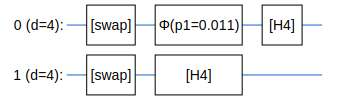

In [30]:
q0 = cirq.LineQid(0, dimension=4)
q1 = cirq.LineQid(1, dimension=4)

circuit = cirq.Circuit(

    QuditSwapGate().on(q0),
    QuquartDepolarizingChannel().on(q0),
    QuditHGate().on(q0),
    QuditSwapGate().on(q1),
    QuditHGate().on(q1),
#     cirq.measure(q0),
#     cirq.measure(q1),
)

SVGCircuit(circuit)    

In [31]:
%matplotlib notebook
repetitions = 1024
# simulator = cirq.Simulator()
simulator = cirq.DensityMatrixSimulator()
# circuit = circuit.with_noise(QuditHGate)
# circuit.insert(0, QuditHGate.on(q0))
# result = simulator.run(circuit, repetitions=repetitions)

for step_result in simulator.simulate_moment_steps(circuit):
    print(step_result.density_matrix())
    
    
# arr_for_hist = []
# for i in range(repetitions):
#     arr_for_hist.append([])
#     for key in result.measurements:
#         arr_for_hist[i].append(result.measurements[key][i][0])
#     arr_for_hist[i] = "".join(map(str, arr_for_hist[i]))

# plt.hist(arr_for_hist, bins=40)


[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j